# Facial Landmark completion

## Imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPool2D, SpatialDropout2D, Concatenate, LeakyReLU

from model_utility import IMAGE_SIZE, LandmarkCutoutImageIterator

In [2]:
tf.get_logger().setLevel('ERROR')

## Constants

In [3]:
LANDMARKS_CSV_PATH = r'../Dataset/list_landmarks_align_celeba.csv'
RANDOM_STATE = 7
VAL_SPLIT = 0.1
BATCH_SIZE = 128
TRAIN_STEPS = 1_000
VAL_STEPS = 100
LEARNING_RATE = 0.0004
LR_ALPHA = 0.3
EPOCHS = 10
PLOTS_DPI = 150

## Data Loading

In [4]:
landmark_df = pd.read_csv(LANDMARKS_CSV_PATH)
landmark_df.head()

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,69,109,106,113,77,142,73,152,108,154
1,000002.jpg,69,110,107,112,81,135,70,151,108,153
2,000003.jpg,76,112,104,106,108,128,74,156,98,158
3,000004.jpg,72,113,108,108,101,138,71,155,101,151
4,000005.jpg,66,114,112,112,86,119,71,147,104,150


In [5]:
landmark_df.shape

(202599, 11)

In [6]:
train_df, val_df = train_test_split(landmark_df, test_size = VAL_SPLIT, random_state =  RANDOM_STATE)
train_df.shape, val_df.shape

((182339, 11), (20260, 11))

In [7]:
train_df.head()

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
164385,164386.jpg,68,112,109,112,83,135,69,151,107,151
113320,113321.jpg,69,112,108,111,88,142,67,152,110,152
149551,149552.jpg,69,110,107,112,95,132,75,152,103,152
88904,088905.jpg,69,112,108,111,88,135,71,151,105,153
169391,169392.jpg,67,110,108,114,100,125,70,150,110,152


In [8]:
val_df.head()

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
57636,057637.jpg,69,111,108,112,84,138,71,151,107,152
166366,166367.jpg,69,112,108,111,88,133,74,152,103,152
185783,185784.jpg,69,111,108,111,84,136,70,152,107,151
139545,139546.jpg,69,111,108,111,91,134,73,152,105,152
144025,144026.jpg,72,110,105,110,81,131,76,154,101,155


In [9]:
train_iter = LandmarkCutoutImageIterator(train_df, BATCH_SIZE, TRAIN_STEPS)
val_iter = LandmarkCutoutImageIterator(val_df, BATCH_SIZE, VAL_STEPS)

train_iter, val_iter

(<model_utility.LandmarkCutoutImageIterator at 0x2002263f850>,
 <model_utility.LandmarkCutoutImageIterator at 0x2002263fb50>)

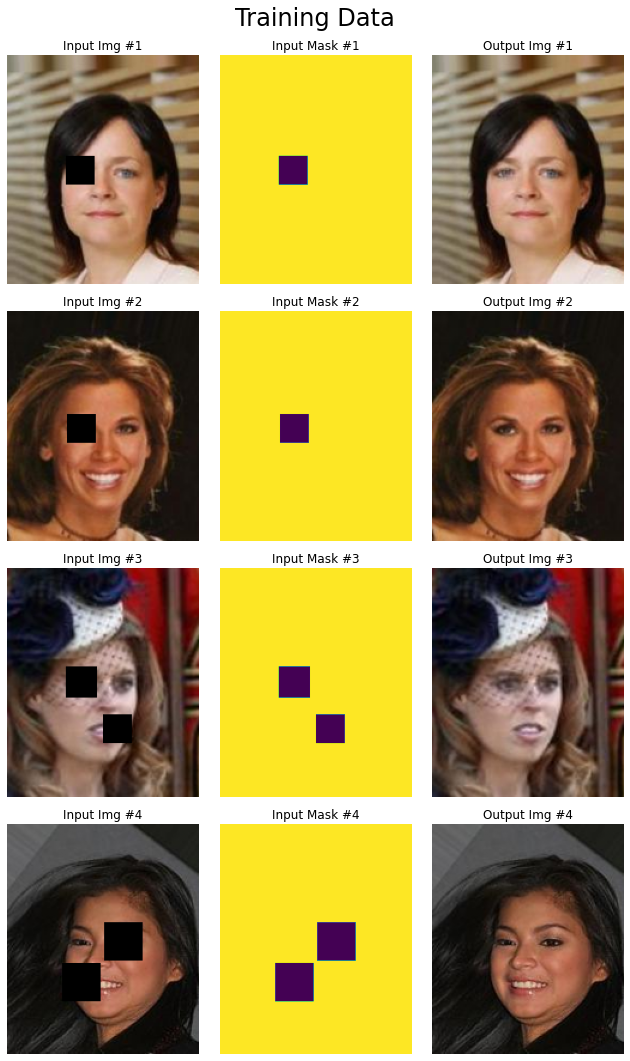

In [10]:
sample_data = train_iter[0]

fig, axes = plt.subplots(4, 3, figsize = (9, 15))

for i in range(4):
    axes[i][0].imshow(sample_data[0][0][i])
    axes[i][0].set_title(f"Input Img #{i + 1}")

    axes[i][1].imshow(sample_data[0][1][i])
    axes[i][1].set_title(f"Input Mask #{i + 1}")

    axes[i][2].imshow(sample_data[1][i])
    axes[i][2].set_title(f"Output Img #{i + 1}")

axes = axes.flatten()

for ax in axes:
    ax.axis(False)
    ax.grid(False)

plt.tight_layout(rect = [0, 0, 1, 0.96])
plt.suptitle("Training Data", fontsize = 24)
plt.show()


In [11]:
output_types = ((tf.dtypes.float32, tf.dtypes.float32), tf.dtypes.float32)
output_shapes = (((BATCH_SIZE, *IMAGE_SIZE, 3), (BATCH_SIZE, *IMAGE_SIZE, 1)), (BATCH_SIZE, *IMAGE_SIZE, 3))
train_ds = Dataset.from_generator(train_iter, output_types = output_types, output_shapes = output_shapes).prefetch(buffer_size = AUTOTUNE)
val_ds = Dataset.from_generator(val_iter, output_types = output_types, output_shapes = output_shapes).prefetch(buffer_size = AUTOTUNE)

train_ds, val_ds

(<PrefetchDataset shapes: (((128, 192, 160, 3), (128, 192, 160, 1)), (128, 192, 160, 3)), types: ((tf.float32, tf.float32), tf.float32)>,
 <PrefetchDataset shapes: (((128, 192, 160, 3), (128, 192, 160, 1)), (128, 192, 160, 3)), types: ((tf.float32, tf.float32), tf.float32)>)

## Model Creation

In [12]:
def get_model():
    img_input_layer = Input(shape = (*IMAGE_SIZE, 3), name = 'Img_Input_Layer')
    mask_input_layer = Input(shape = (*IMAGE_SIZE, 1), name = 'Mask_Input_Layer')
    concat_inputs = Concatenate(name = "Concatenated_Inputs")([img_input_layer, mask_input_layer])

    conv_1 = Conv2D(16, 6, padding = 'same', activation = LeakyReLU(LR_ALPHA), name = 'Conv_1')(concat_inputs)
    pool_1 = MaxPool2D(name = 'Max_Pool_1')(conv_1)
    conv_2 = Conv2D(32, 6, padding = 'same', activation = LeakyReLU(LR_ALPHA), name = 'Conv_2')(pool_1)
    pool_2 = MaxPool2D(name = 'Max_Pool_2')(conv_2)
    spd_1 = SpatialDropout2D(0.1, name = 'SPD_1')(pool_2)
    
    conv_3 = Conv2D(64, 4, padding = 'same', activation = LeakyReLU(LR_ALPHA), name = 'Conv_3')(spd_1)
    pool_3 = MaxPool2D(name = 'Max_Pool_3')(conv_3)
    conv_4 = Conv2D(128, 4, padding = 'same', activation = LeakyReLU(LR_ALPHA), name = 'Conv_4')(pool_3)
    pool_4 = MaxPool2D(name = 'Max_Pool_4')(conv_4)
    spd_2 = SpatialDropout2D(0.1, name = 'SPD_2')(pool_4)
    
    conv_5 = Conv2D(256, 2, padding = 'same', activation = LeakyReLU(LR_ALPHA), name = 'Conv_5')(spd_2)
    pool_5 = MaxPool2D(name = 'Max_Pool_5')(conv_5)
    spd_3 = SpatialDropout2D(0.1, name = 'SPD_3')(pool_5)
    
    conv_t_1 = Conv2DTranspose(128, 2, padding = 'same', strides = 2, activation = LeakyReLU(LR_ALPHA), name = 'Conv_T_1')(spd_3)
    concat_1 = Concatenate(name = 'Concat_1')([conv_t_1, pool_4])
    spd_4 = SpatialDropout2D(0.1, name = 'SPD_4')(concat_1)
    
    conv_t_2 = Conv2DTranspose(64, 4, padding = 'same', strides = 2, activation = LeakyReLU(LR_ALPHA), name = 'Conv_T_2')(spd_4)
    conv_t_3 = Conv2DTranspose(32, 4, padding = 'same', strides = 2, activation = LeakyReLU(LR_ALPHA), name = 'Conv_T_3')(conv_t_2)
    concat_2 = Concatenate(name = 'Concat_2')([conv_t_3, pool_2])
    spd_5 = SpatialDropout2D(0.1, name = 'SPD_5')(concat_2)
    
    conv_t_4 = Conv2DTranspose(16, 6, padding = 'same', strides = 2, activation = LeakyReLU(LR_ALPHA), name = 'Conv_T_4')(spd_5)
    conv_t_5 = Conv2DTranspose(3, 6, padding = 'same', strides = 2, activation = 'sigmoid', name = 'Conv_T_5')(conv_t_4)

    return Model(inputs = [img_input_layer, mask_input_layer], outputs = conv_t_5, name = 'Facial_Landmark_Completion')

model = get_model()
model.compile(optimizer = Adam(LEARNING_RATE), loss = 'binary_crossentropy', metrics = ['mse'])
model.summary()

Model: "Facial_Landmark_Completion"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Img_Input_Layer (InputLayer)    [(None, 192, 160, 3) 0                                            
__________________________________________________________________________________________________
Mask_Input_Layer (InputLayer)   [(None, 192, 160, 1) 0                                            
__________________________________________________________________________________________________
Concatenated_Inputs (Concatenat (None, 192, 160, 4)  0           Img_Input_Layer[0][0]            
                                                                 Mask_Input_Layer[0][0]           
__________________________________________________________________________________________________
Conv_1 (Conv2D)                 (None, 192, 160, 16) 2320        Concaten

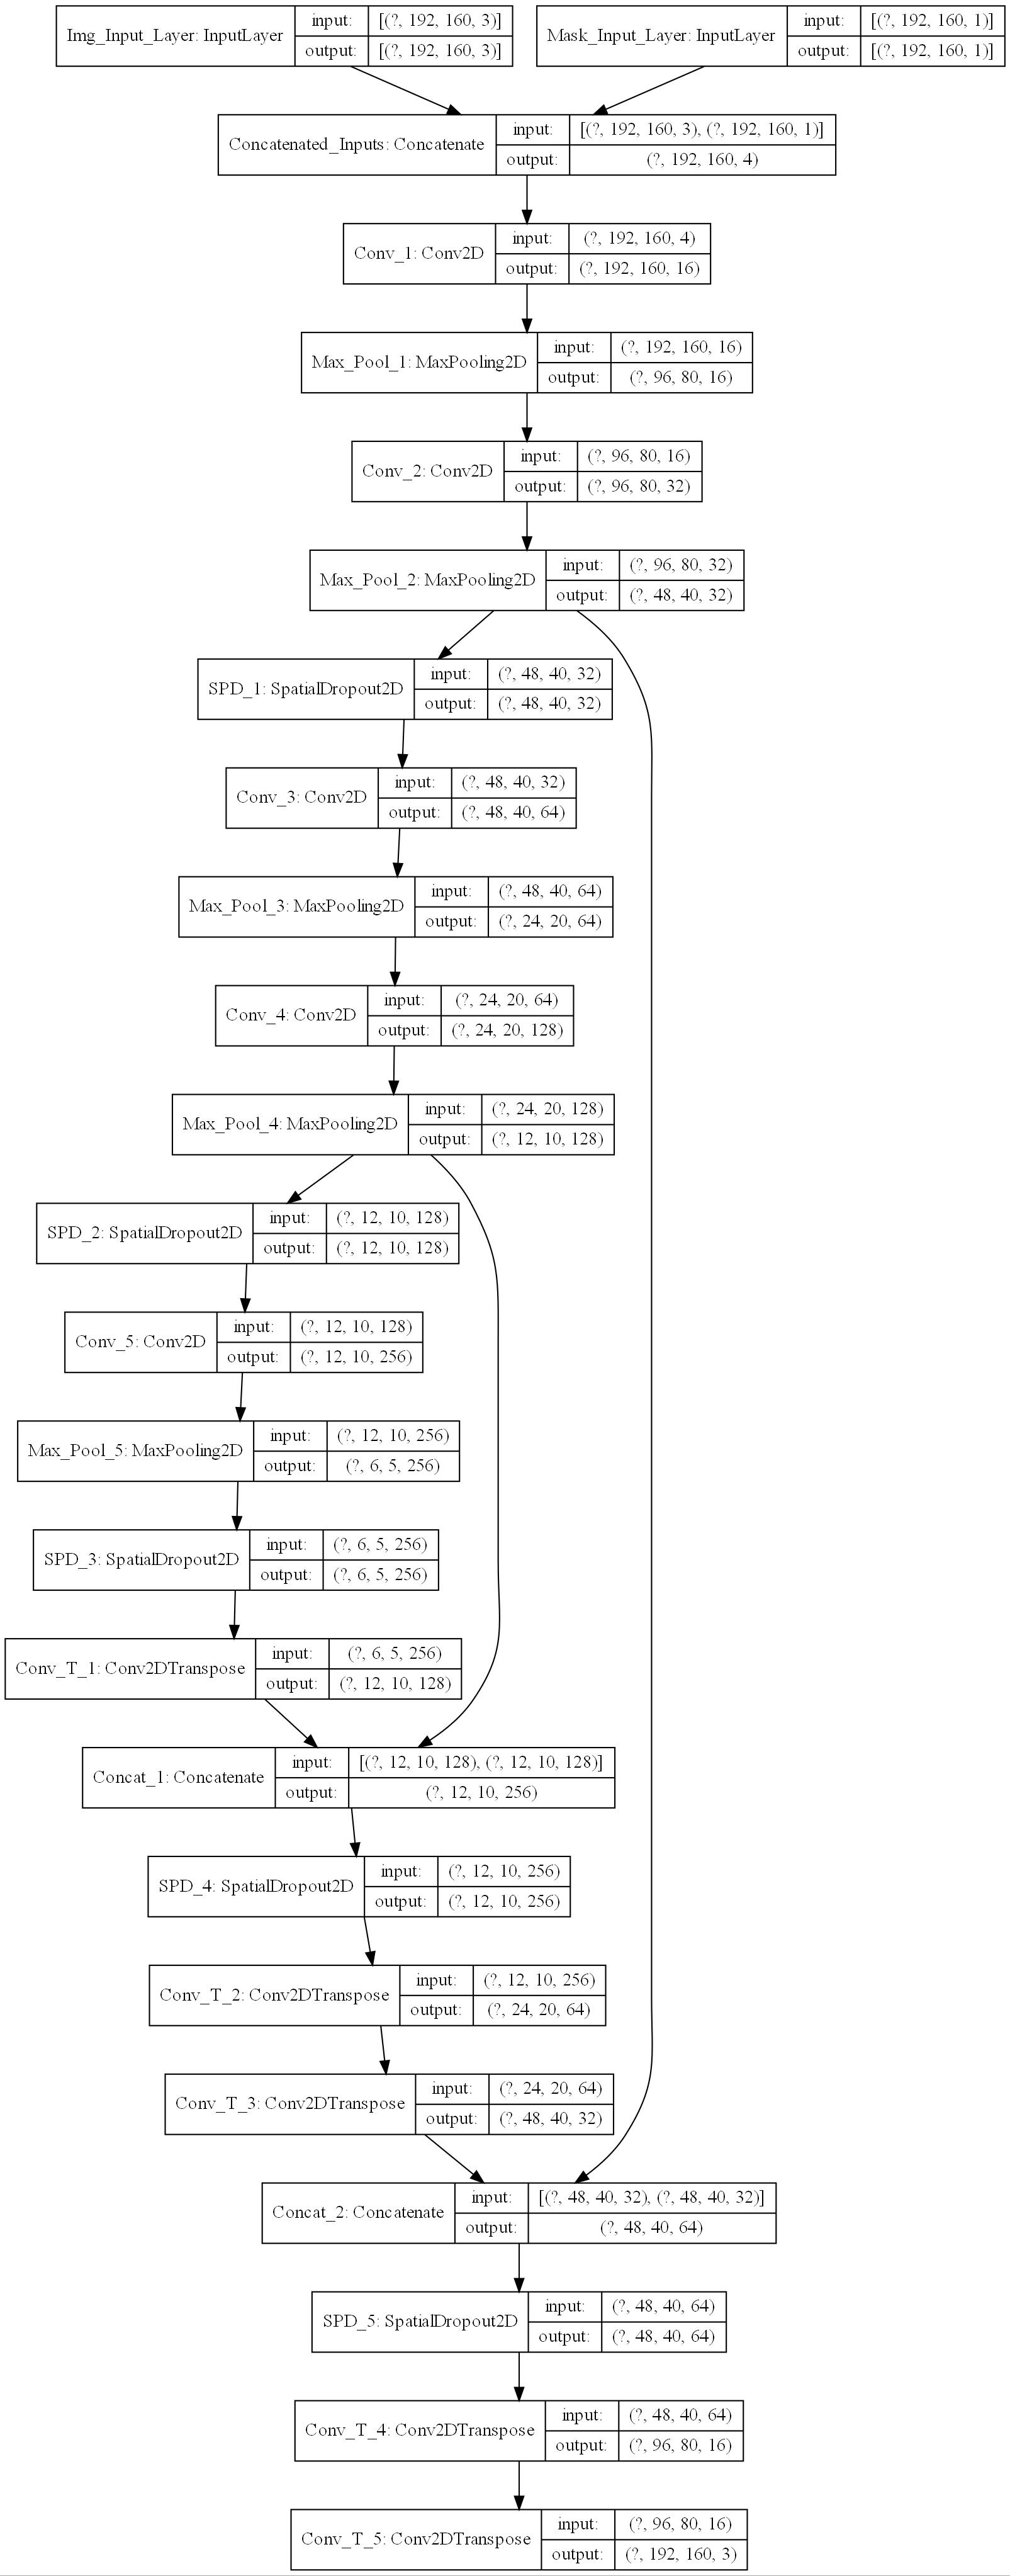

In [13]:
plot_model(model, to_file = 'model.jpg', show_shapes = True, dpi = PLOTS_DPI)

## Model Training

In [14]:
%%time

history = model.fit(train_ds, validation_data = val_ds, epochs = EPOCHS)

Epoch 1/10
1000/1000 [==============================] - 2570s 3s/step - loss: 0.4895 - mse: 0.0069 - val_loss: 0.4796 - val_mse: 0.0026
Epoch 2/10
1000/1000 [==============================] - 1657s 2s/step - loss: 0.4783 - mse: 0.0025 - val_loss: 0.4775 - val_mse: 0.0019
Epoch 3/10
1000/1000 [==============================] - 1086s 1s/step - loss: 0.4768 - mse: 0.0021 - val_loss: 0.4763 - val_mse: 0.0017
Epoch 4/10
1000/1000 [==============================] - 879s 879ms/step - loss: 0.4758 - mse: 0.0019 - val_loss: 0.4746 - val_mse: 0.0016
Epoch 5/10
1000/1000 [==============================] - 1160s 1s/step - loss: 0.4757 - mse: 0.0018 - val_loss: 0.4760 - val_mse: 0.0014
Epoch 6/10
1000/1000 [==============================] - 908s 908ms/step - loss: 0.4757 - mse: 0.0017 - val_loss: 0.4747 - val_mse: 0.0014
Epoch 7/10
1000/1000 [==============================] - 632s 632ms/step - loss: 0.4759 - mse: 0.0016 - val_loss: 0.4753 - val_mse: 0.0014
Epoch 8/10
1000/1000 [====================

## Model Evaluation

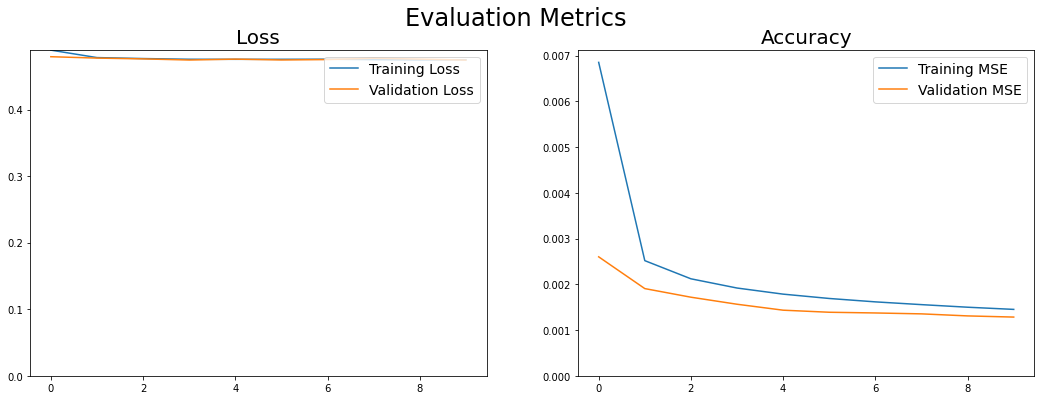

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']

mse = history.history['mse']
val_mse = history.history['val_mse']

epochs_range = history.epoch

plt.figure(figsize = (18, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right', fontsize = 14)
plt.ylim(0, None)
plt.title('Loss', fontsize = 20)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, mse, label = 'Training MSE')
plt.plot(epochs_range, val_mse, label = 'Validation MSE')
plt.legend(loc = 'upper right', fontsize = 14)
plt.ylim(0, None)
plt.title('Accuracy', fontsize = 20)

plt.suptitle("Evaluation Metrics", fontsize = 24)
plt.savefig('loss.jpg', dpi = PLOTS_DPI, bbox_inches = 'tight')
plt.show()

## Predictions

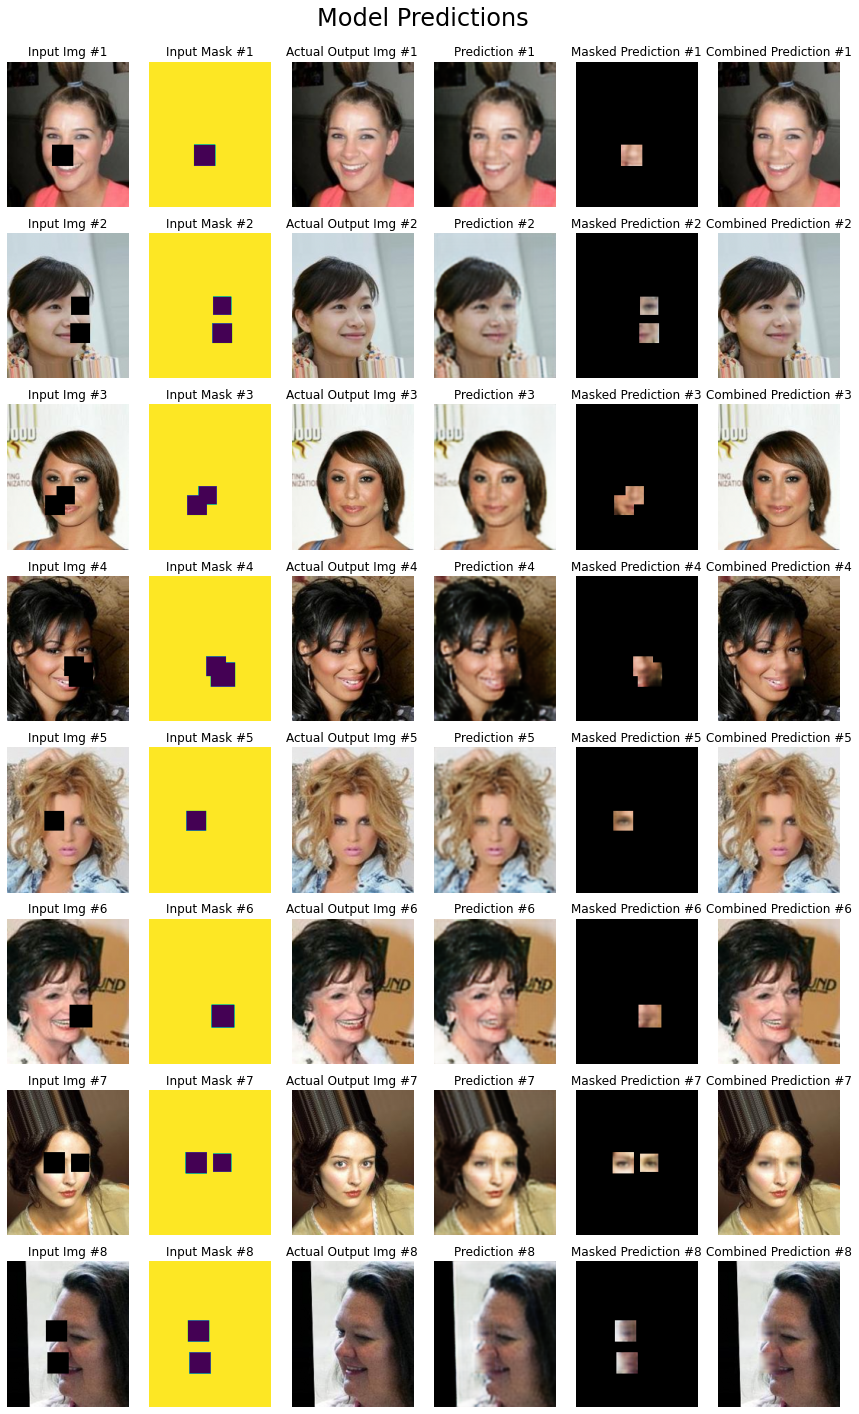

In [16]:
sample_data = val_iter[0][:8]
imgs = img = sample_data[0][0]
masks = mask = sample_data[0][1]
preds = model.predict(sample_data[0])

fig, axes = plt.subplots(8, 6, figsize = (12, 20))

for i in range(8):

    axes[i][0].imshow(imgs[i])
    axes[i][0].set_title(f"Input Img #{i + 1}")

    axes[i][1].imshow(masks[i])
    axes[i][1].set_title(f"Input Mask #{i + 1}")

    axes[i][2].imshow(sample_data[1][i])
    axes[i][2].set_title(f"Actual Output Img #{i + 1}")

    axes[i][3].imshow(preds[i])
    axes[i][3].set_title(f"Prediction #{i + 1}")

    masked_pred = preds[i] * (1 - masks[i])

    axes[i][4].imshow(masked_pred)
    axes[i][4].set_title(f"Masked Prediction #{i + 1}")

    combined_pred = (imgs[i] * masks[i]) + masked_pred

    axes[i][5].imshow(combined_pred)
    axes[i][5].set_title(f"Combined Prediction #{i + 1}")

axes = axes.flatten()

for ax in axes:
    ax.axis(False)
    ax.grid(False)

plt.tight_layout(rect = [0, 0, 1, 0.96])
plt.suptitle("Model Predictions", fontsize = 24)
plt.savefig('predictions.jpg', dpi = PLOTS_DPI, bbox_inches = 'tight')
plt.show()

## Saving the model

In [17]:
model.save("face_completion")